# Continuous Normalizing Flow with OT-Flow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EmoryMLIP/DeepGenerativeModelingIntro/blob/main/examples/OTFlow.ipynb)

In [11]:
device = "cpu"
# install requirements  (Colab only)
import sys,os
if 'google.colab' in sys.modules:
    dgm_dir = '/content/DeepGenerativeModelingIntro/'

    if not os.path.exists(dgm_dir):
        !git clone git://github.com/EmoryMLIP/DeepGenerativeModelingIntro.git
    sys.path.append(os.path.dirname(dgm_dir))

In [12]:
import torch
from torch import nn
import numpy as np
from torch import distributions
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16, "text.usetex": True})
plt.rcParams.update({'image.interpolation' : None})
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

## Some suggested experiments

1. reduce the widths of the moon shapes so that the intrinsic dimensionality reduces to one
1. try a different two-dimensional dataset
1. (expert only) use a different layer with tractable inverse and log-determinant

## Setup the Dataset and Plotting

Text(0.5, 1.0, 'dataset: moons $\\mathbf{x}^{(i)}$')

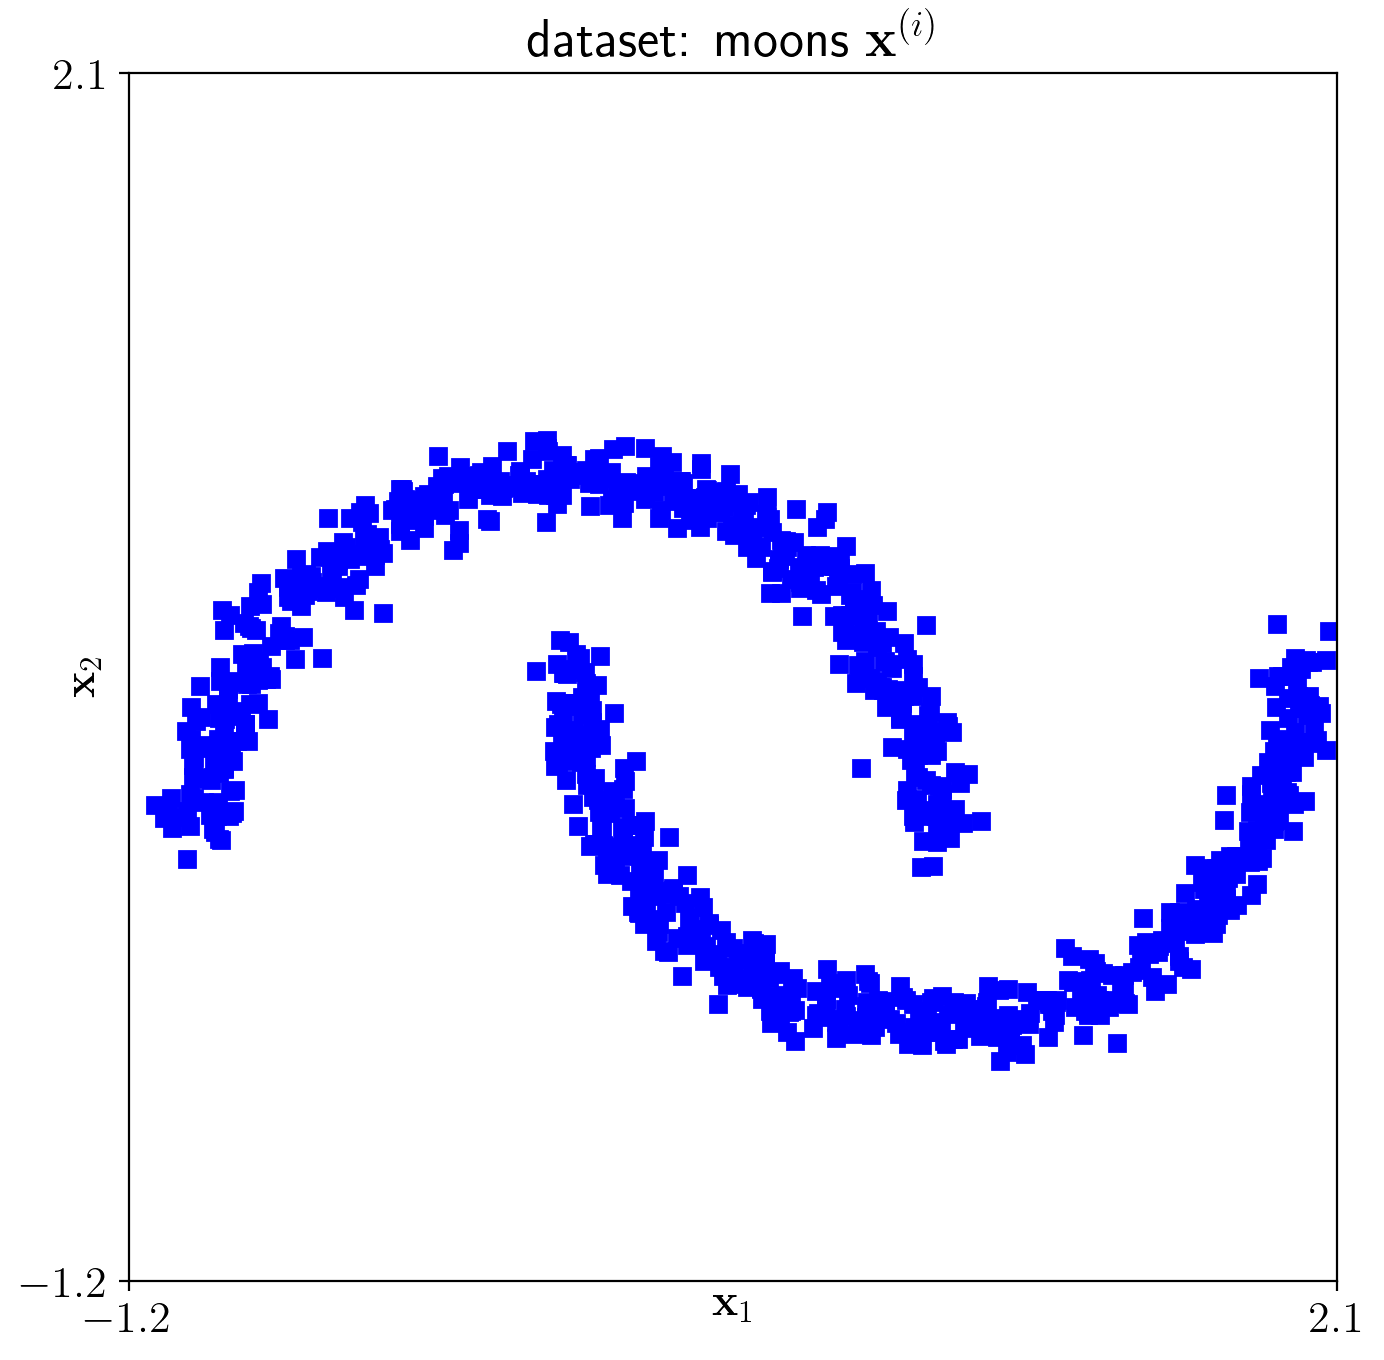

In [13]:
dataset = 'moons'
# dataset = 'uniform'

if dataset == 'moons':
    # grid of the spatial domain (for plotting)
    domain = (-1.2, 2.1, -1.2, 2.1)

    def get_data(batch_size,noise=0.05):
        return torch.tensor(datasets.make_moons(n_samples=batch_size, noise=noise)[0], dtype=torch.float32)
elif dataset == 'uniform':
    domain = (-1.0, 3.0, -1.0, 3.0)
    def get_data(batch_size):
        return torch.rand((batch_size,2)) + 1.0
else:
    print("incorrect dataset")

# grid of the spatial domain (for plotting)
x1 = torch.linspace(domain[0],domain[1], 100)
x2 = torch.linspace(domain[2],domain[3], 100)
xg = torch.meshgrid(x1, x2)
xx = torch.cat((xg[0].reshape(-1, 1), xg[1].reshape(-1, 1)), 1)

from plotting import *

# TODO: Add a plot of data set
xs = get_data(1000)
plot_x(xs,domain)
plt.title("dataset: %s $\mathbf{x}^{(i)}$" % (dataset))

## Choose the Network Architecture

We write the generator as

In [14]:
from OTFlow import *
from Phi import *
nTh = 2# number of layers
width = 32 # width of network
alph = [1.0,10.0,5.0] # alph[0]-> weight for transport costs, alph[1] and alph[2]-> HJB penalties
net = Phi(nTh=nTh, m=width, d=2, alph=alph)
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
nt = 4                 # number of rk4 steps to solve neural ODE

flow = OTFlow(net, nt, alph, prior, T=1.0)


------device=cpu, nTh=2, width=32, batch_size=256, num_steps=20000------
   step          J        J_L       J_ML      J_HJB    
001000   1.7879e+01  2.9813e-01  1.6892e+00  1.3780e-01  
002000   8.9665e+00  3.4120e-01  7.9759e-01  1.2988e-01  
003000   7.1690e+00  3.5049e-01  6.1804e-01  1.2762e-01  
004000   6.6241e+00  3.4721e-01  5.6451e-01  1.2635e-01  
005000   6.3059e+00  3.4838e-01  5.3379e-01  1.2393e-01  
006000   5.9802e+00  3.5241e-01  5.0185e-01  1.2185e-01  
007000   5.7399e+00  3.5221e-01  4.8149e-01  1.1454e-01  
008000   5.5156e+00  3.5747e-01  4.6013e-01  1.1135e-01  
009000   5.3163e+00  3.6029e-01  4.4170e-01  1.0780e-01  
010000   5.1764e+00  3.6047e-01  4.3005e-01  1.0308e-01  
011000   4.9745e+00  3.6136e-01  4.1494e-01  9.2743e-02  
012000   4.8650e+00  3.6084e-01  4.0644e-01  8.7935e-02  


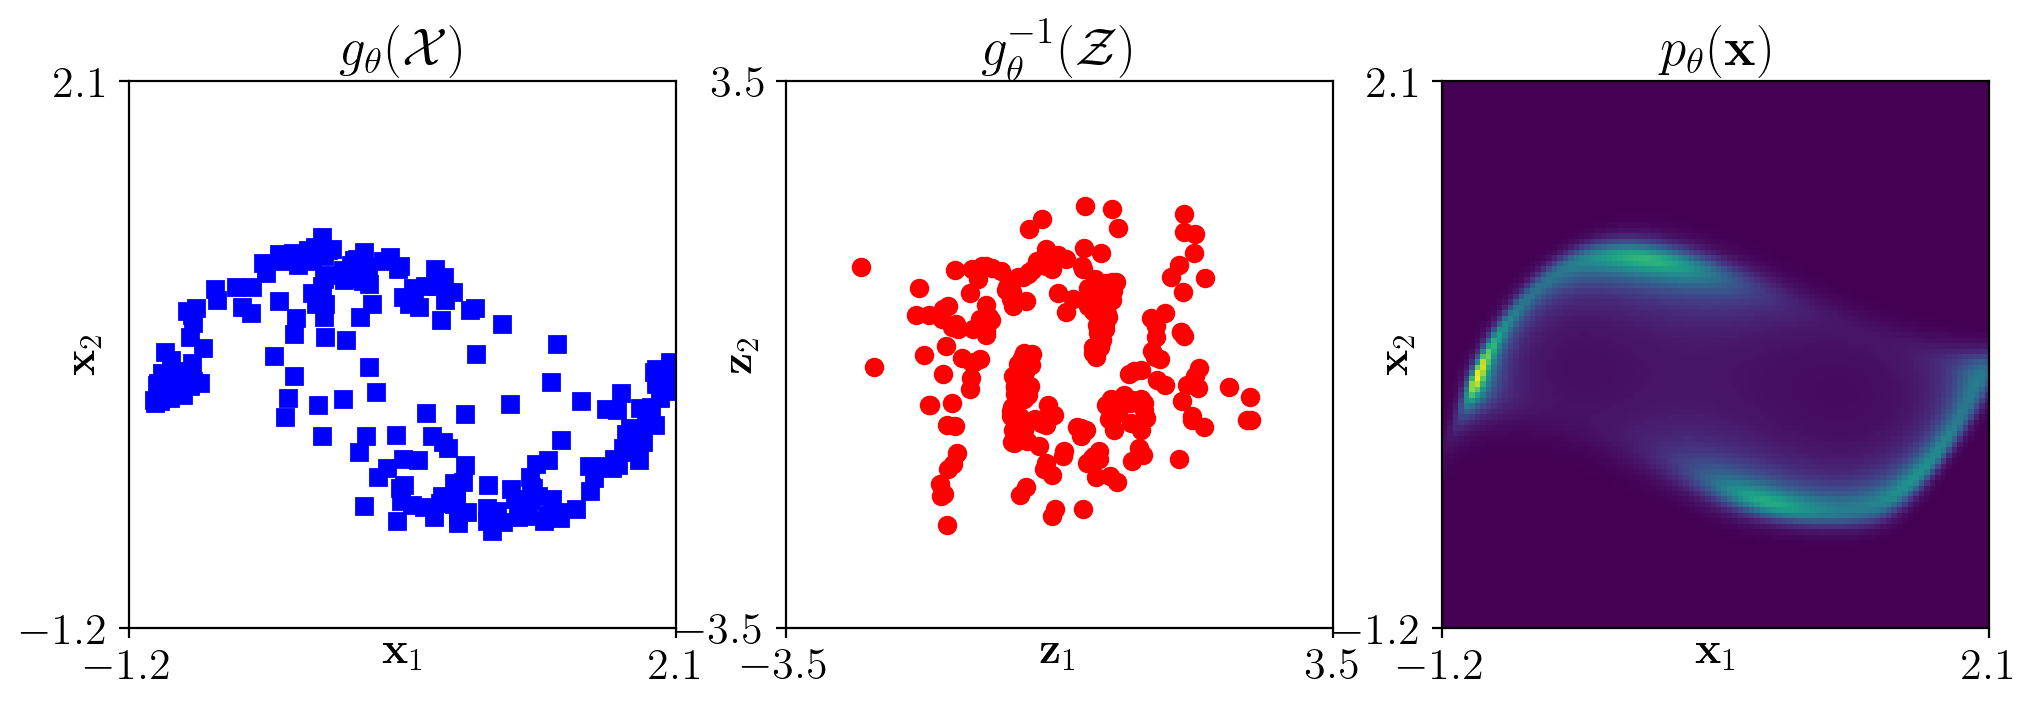

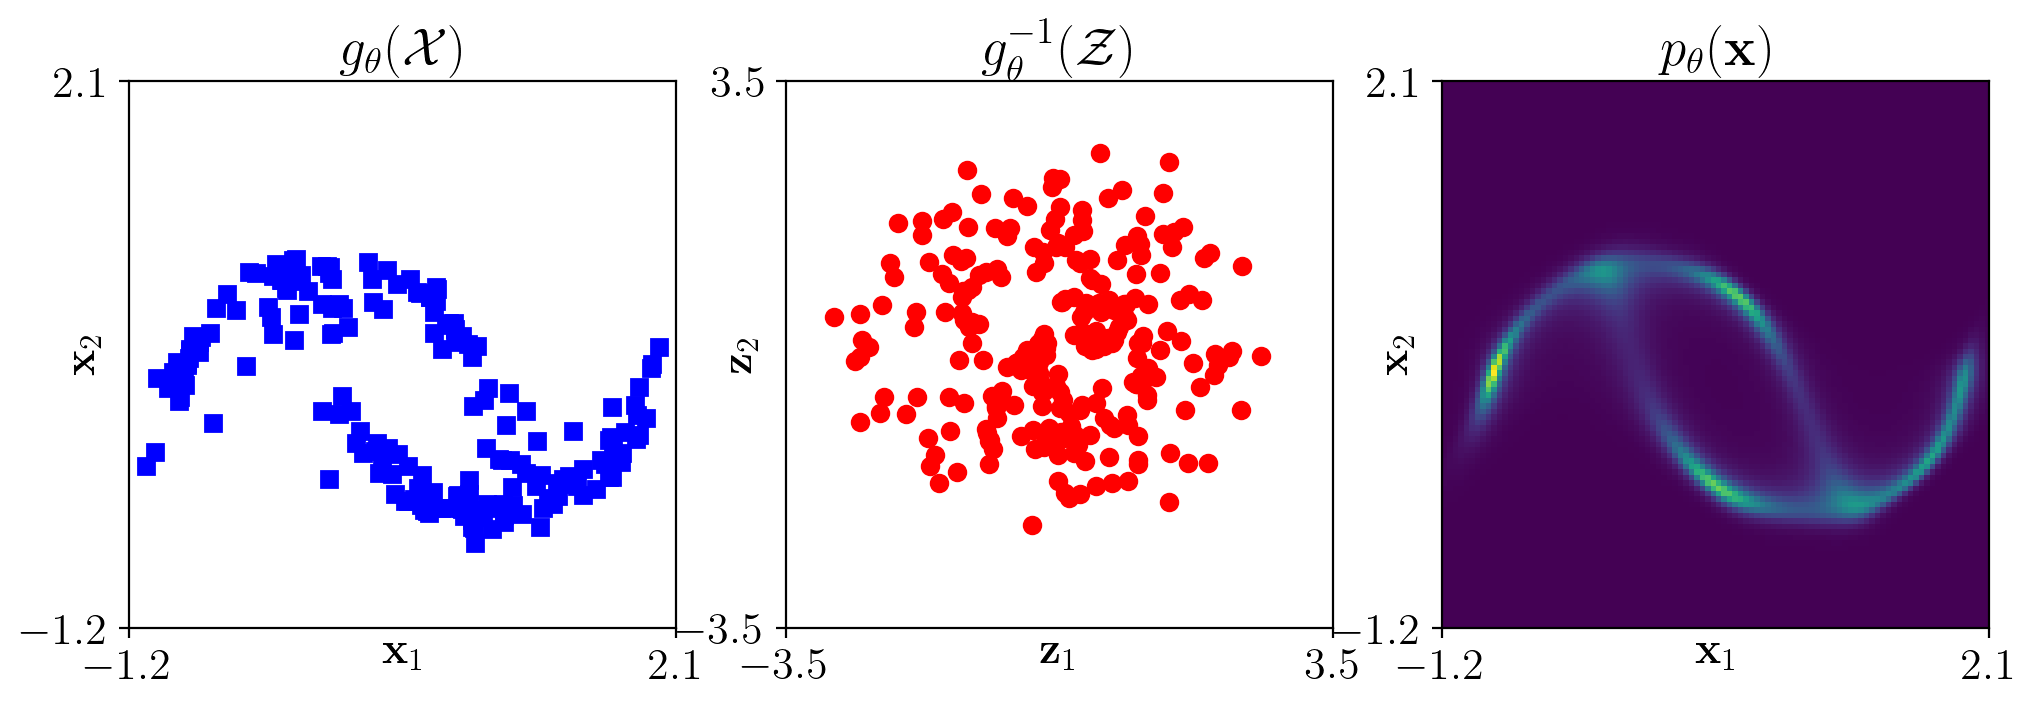

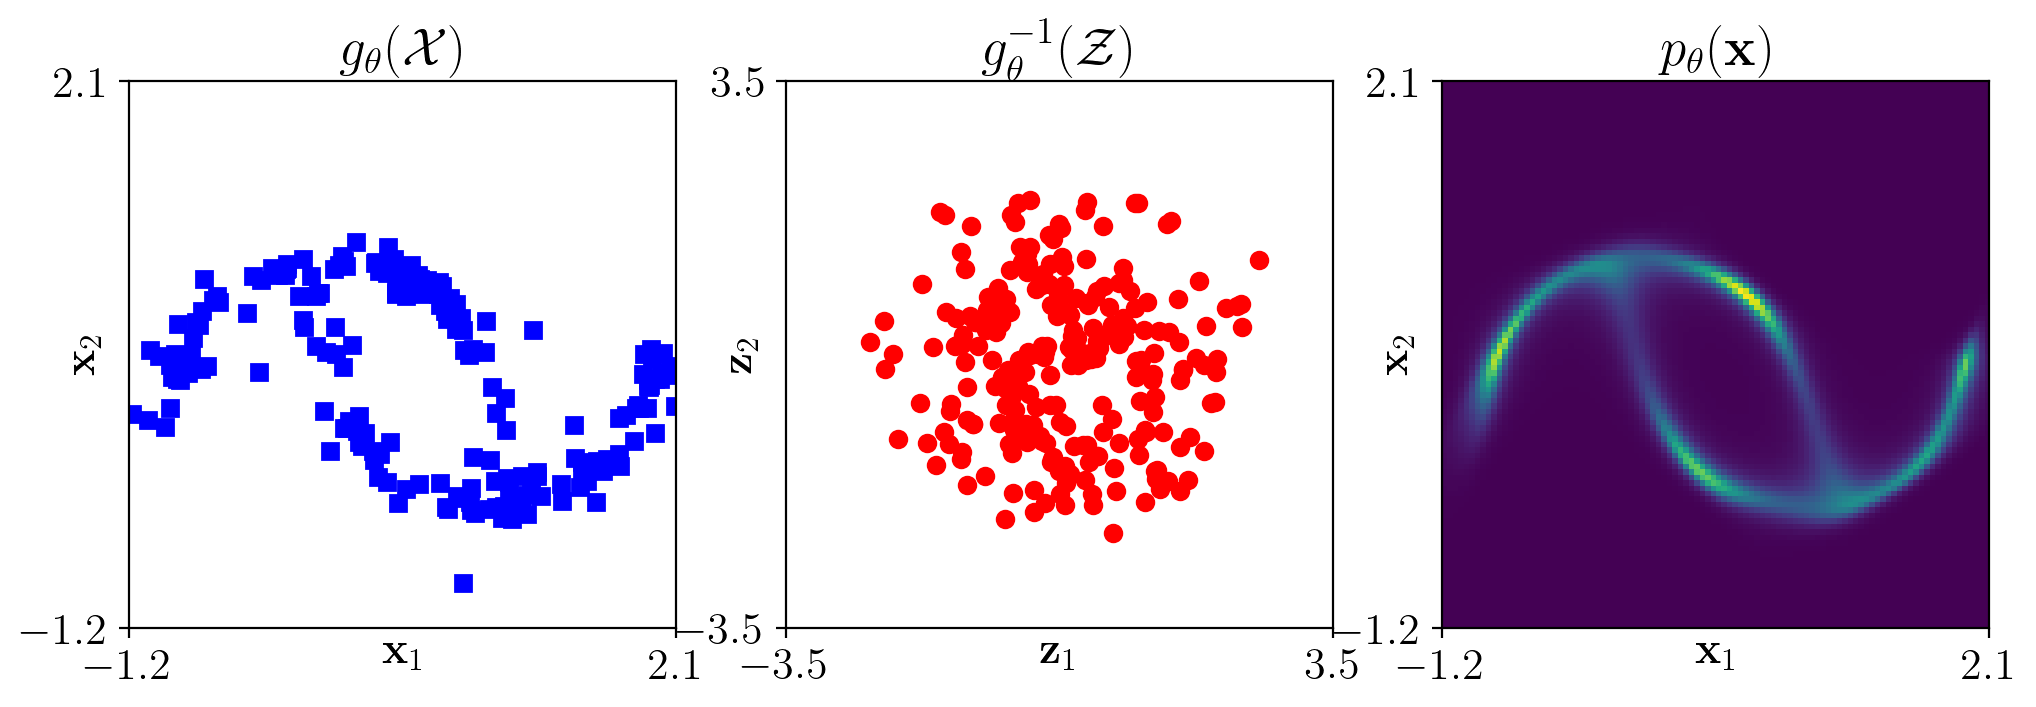

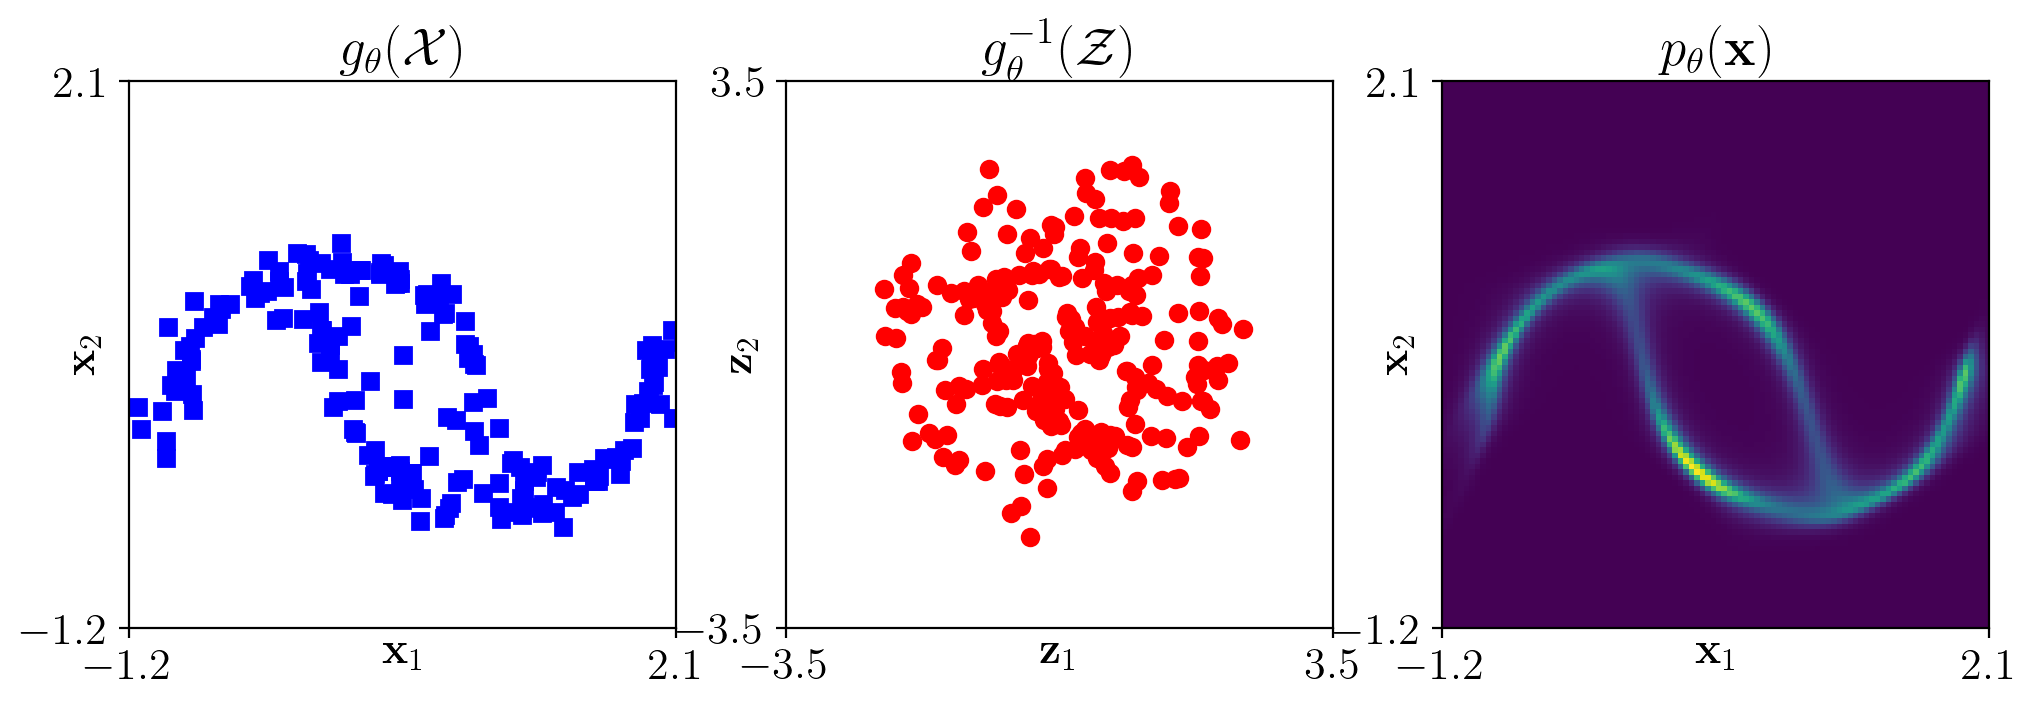

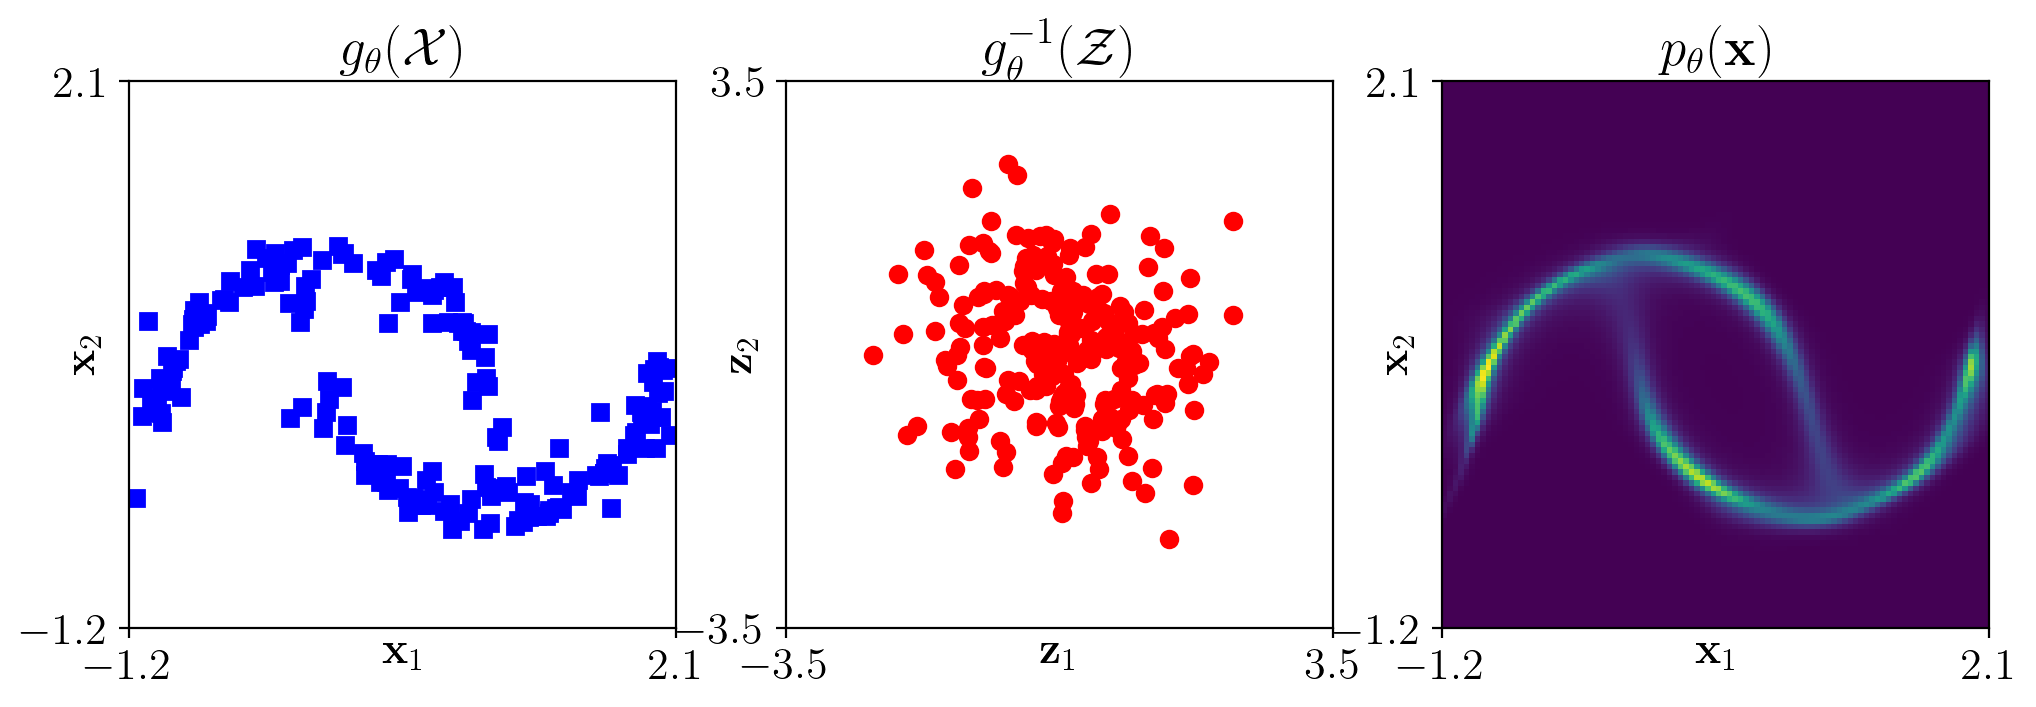

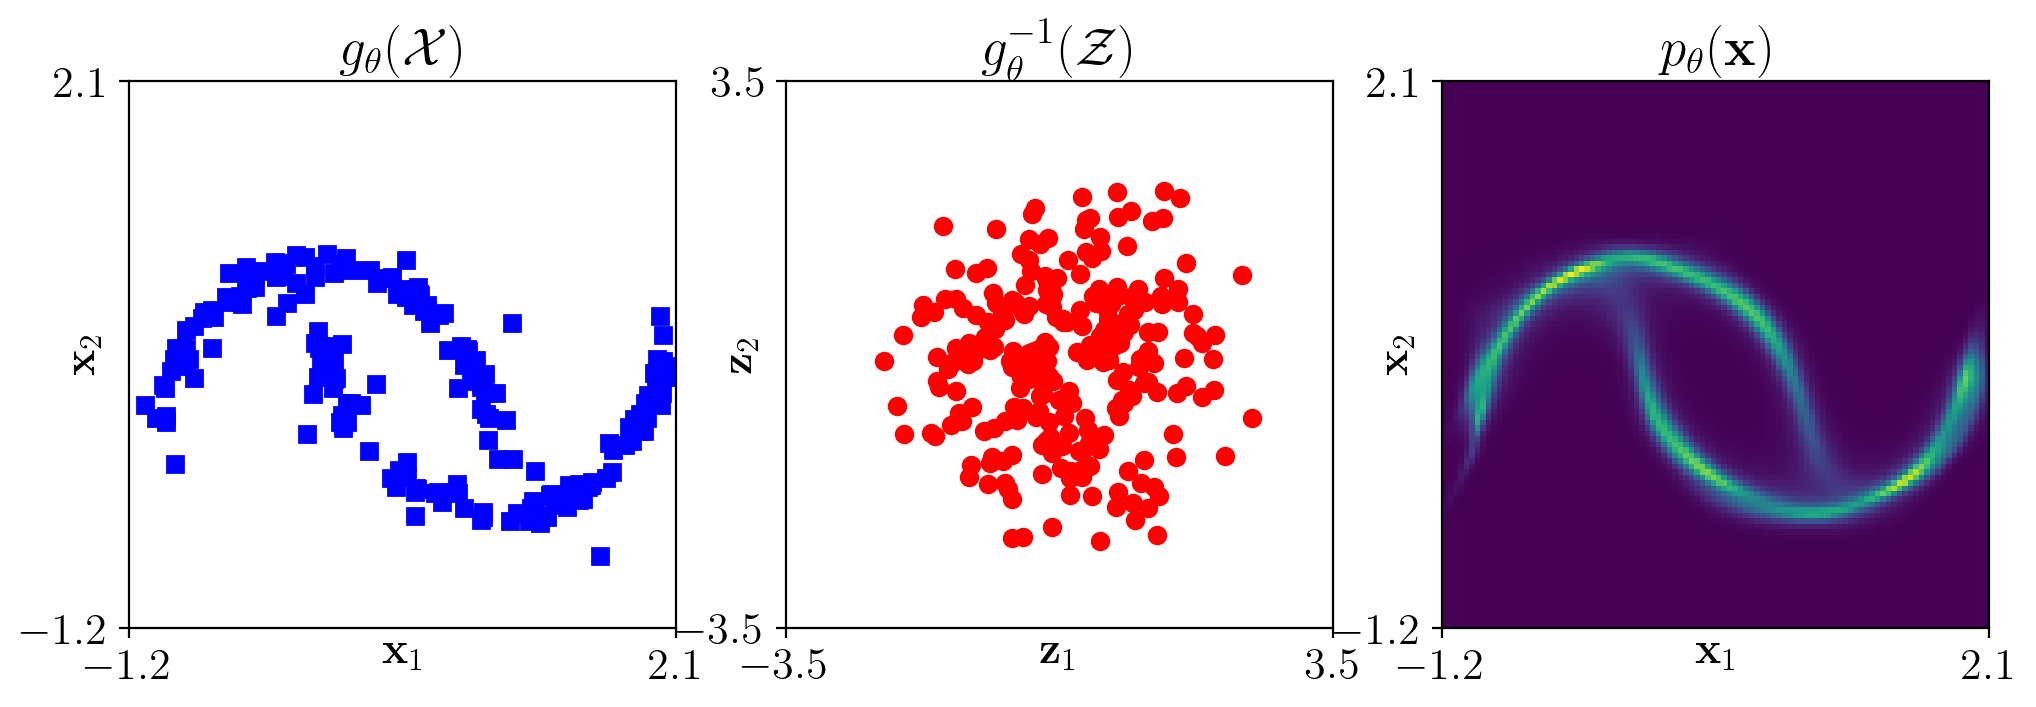

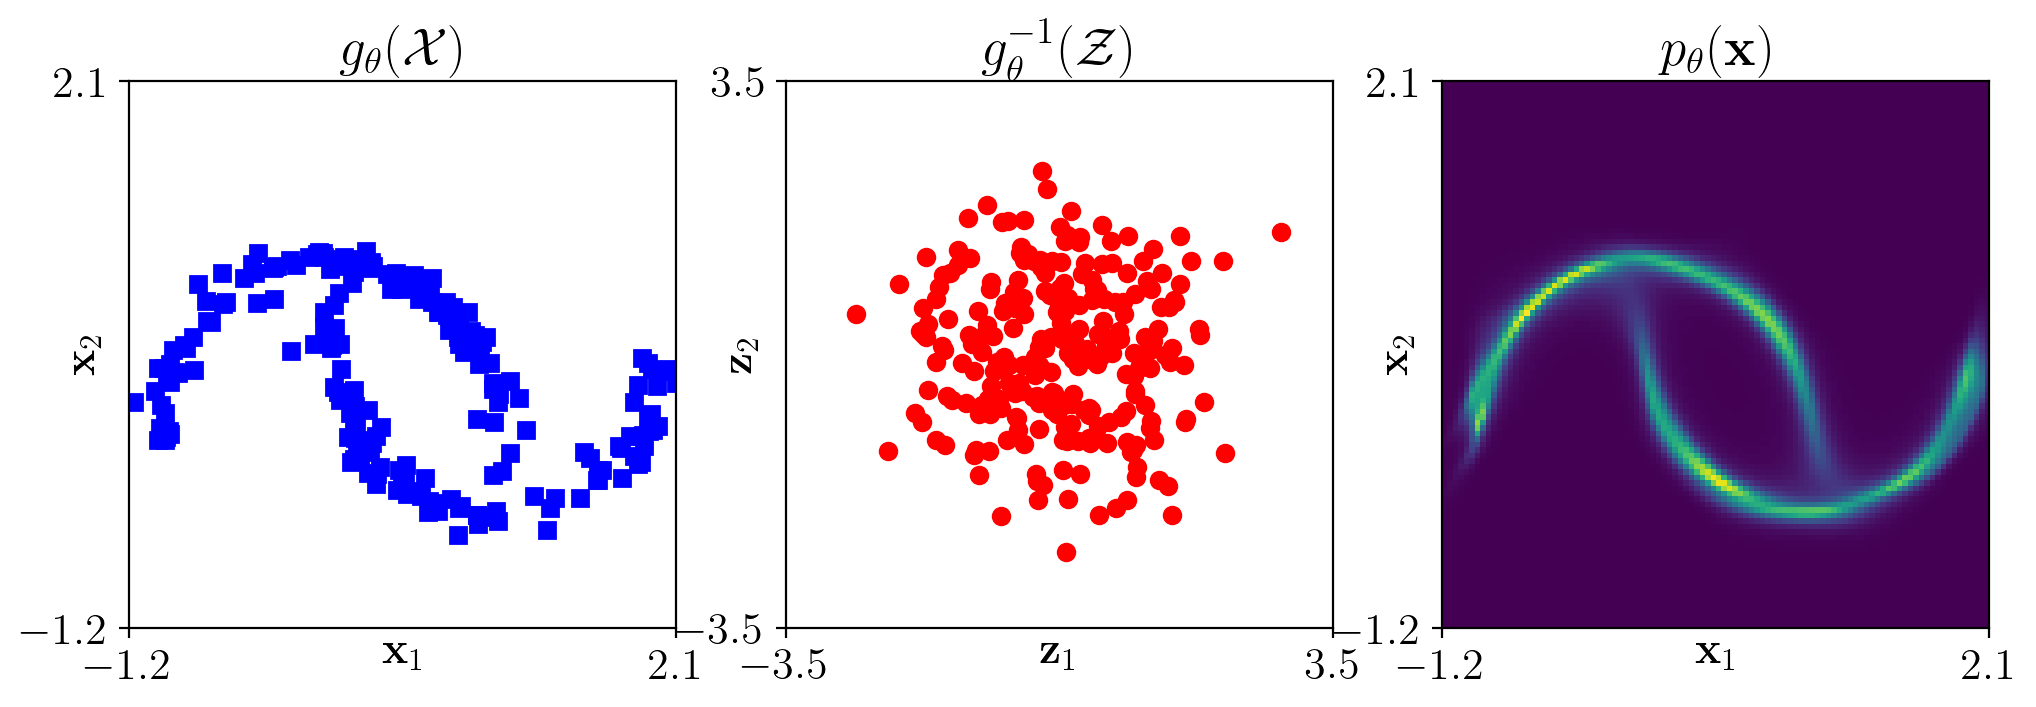

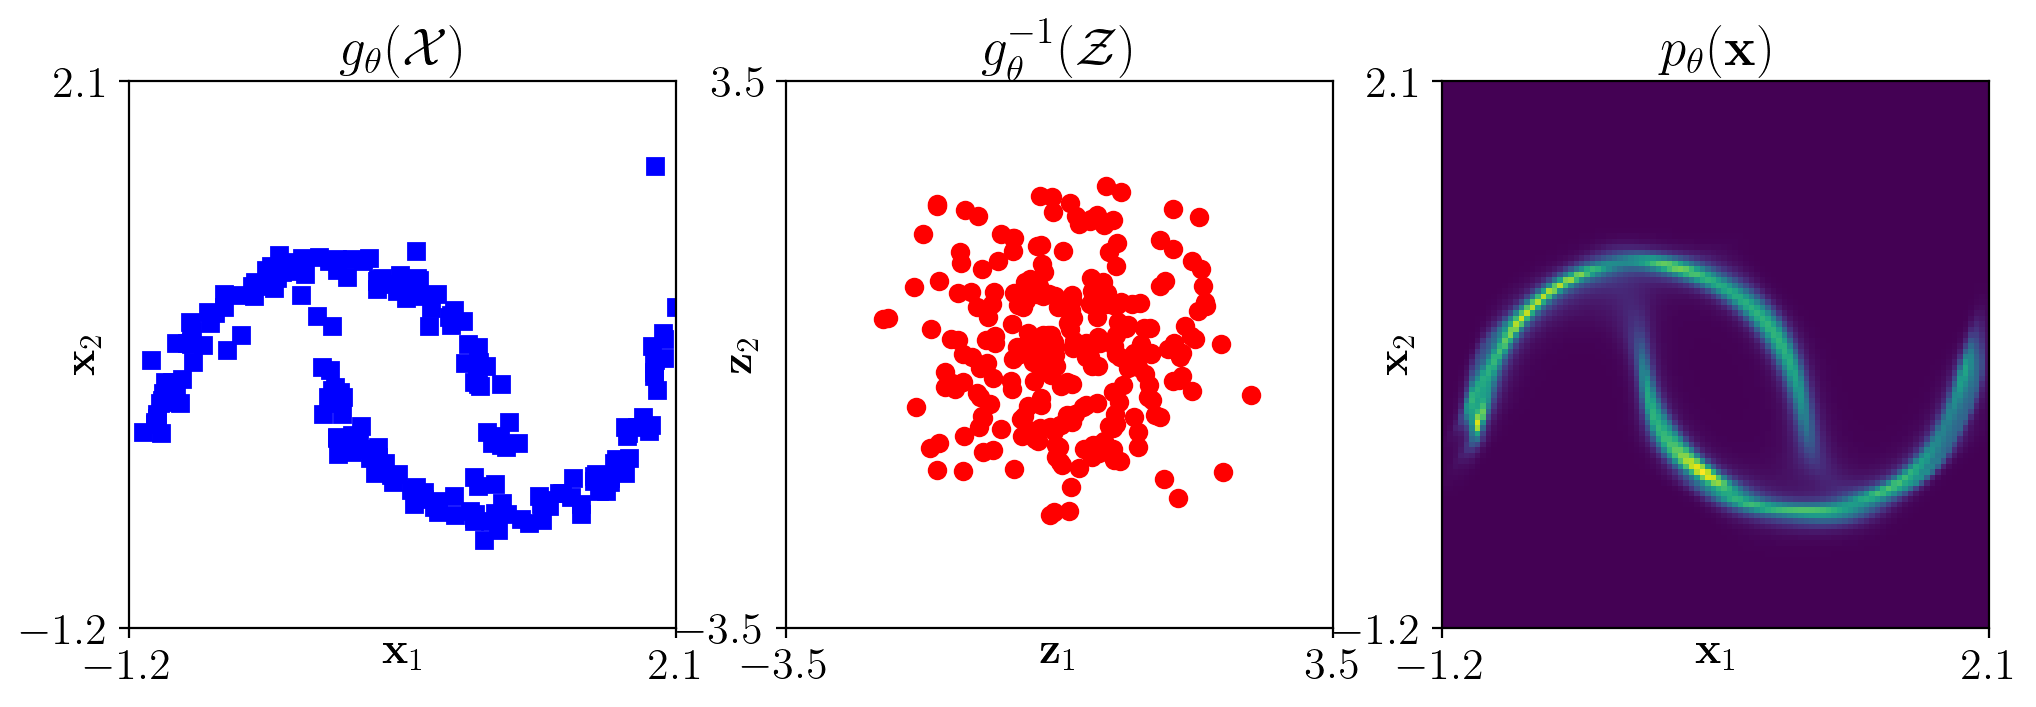

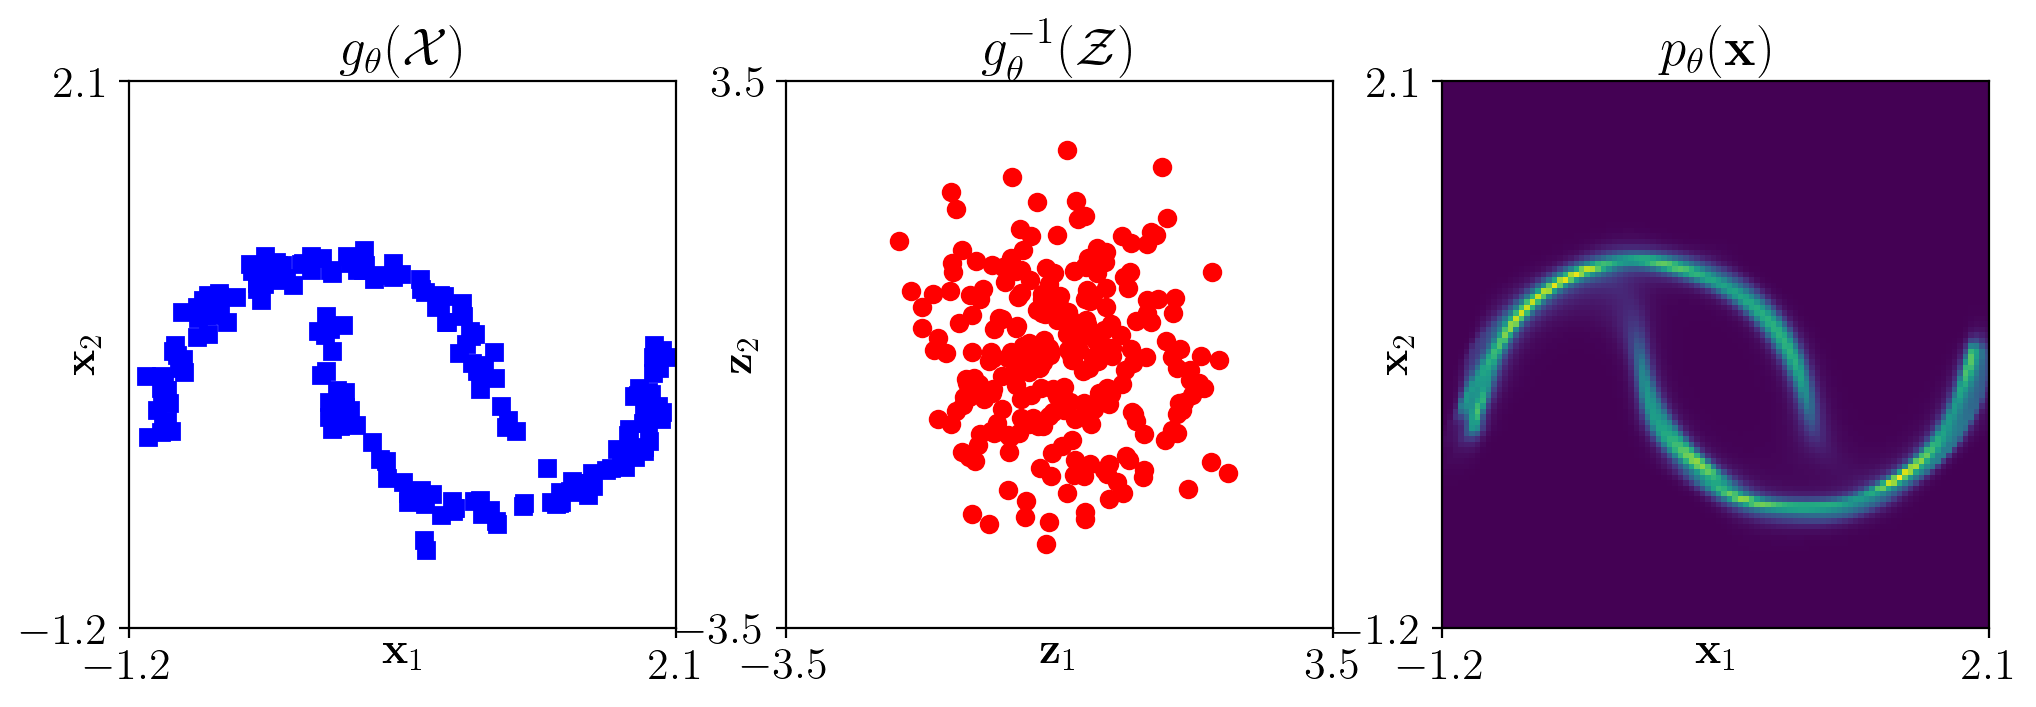

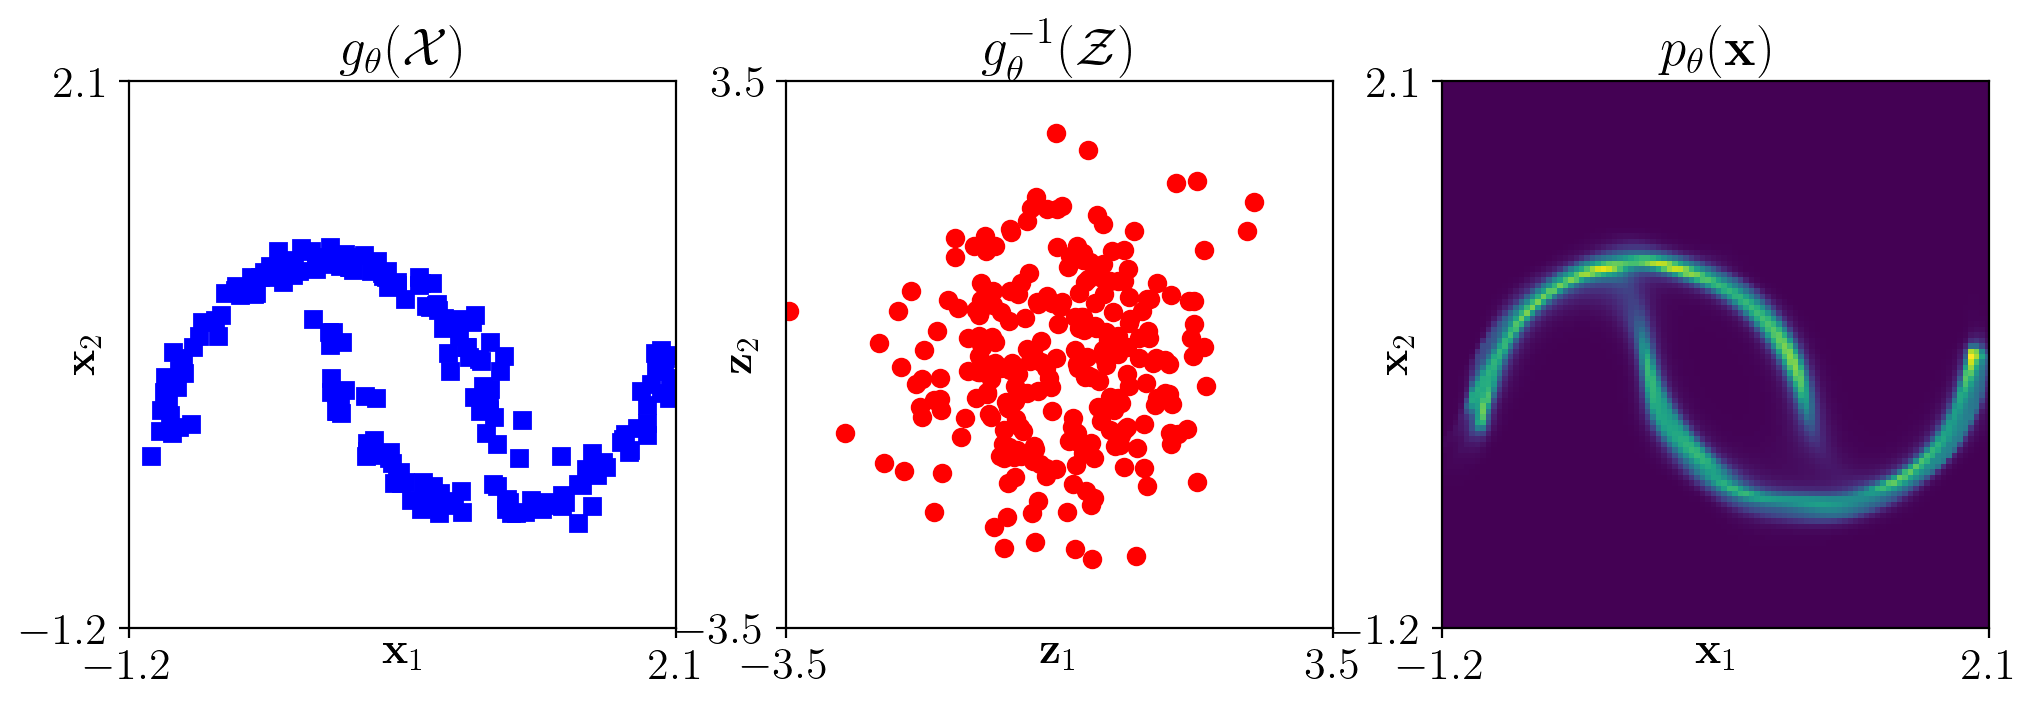

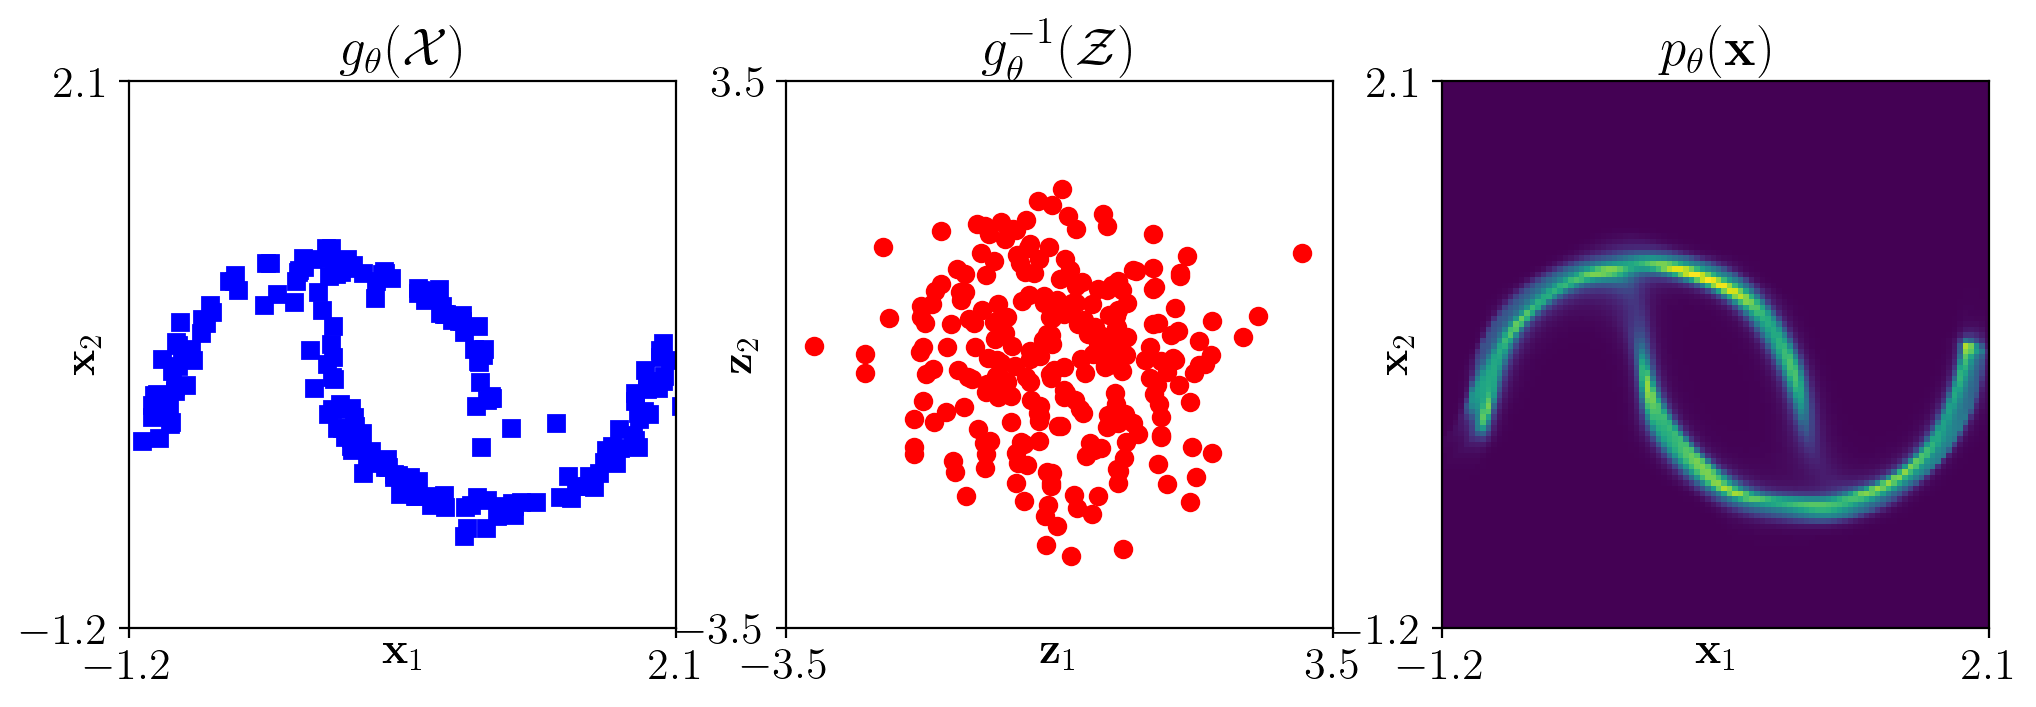

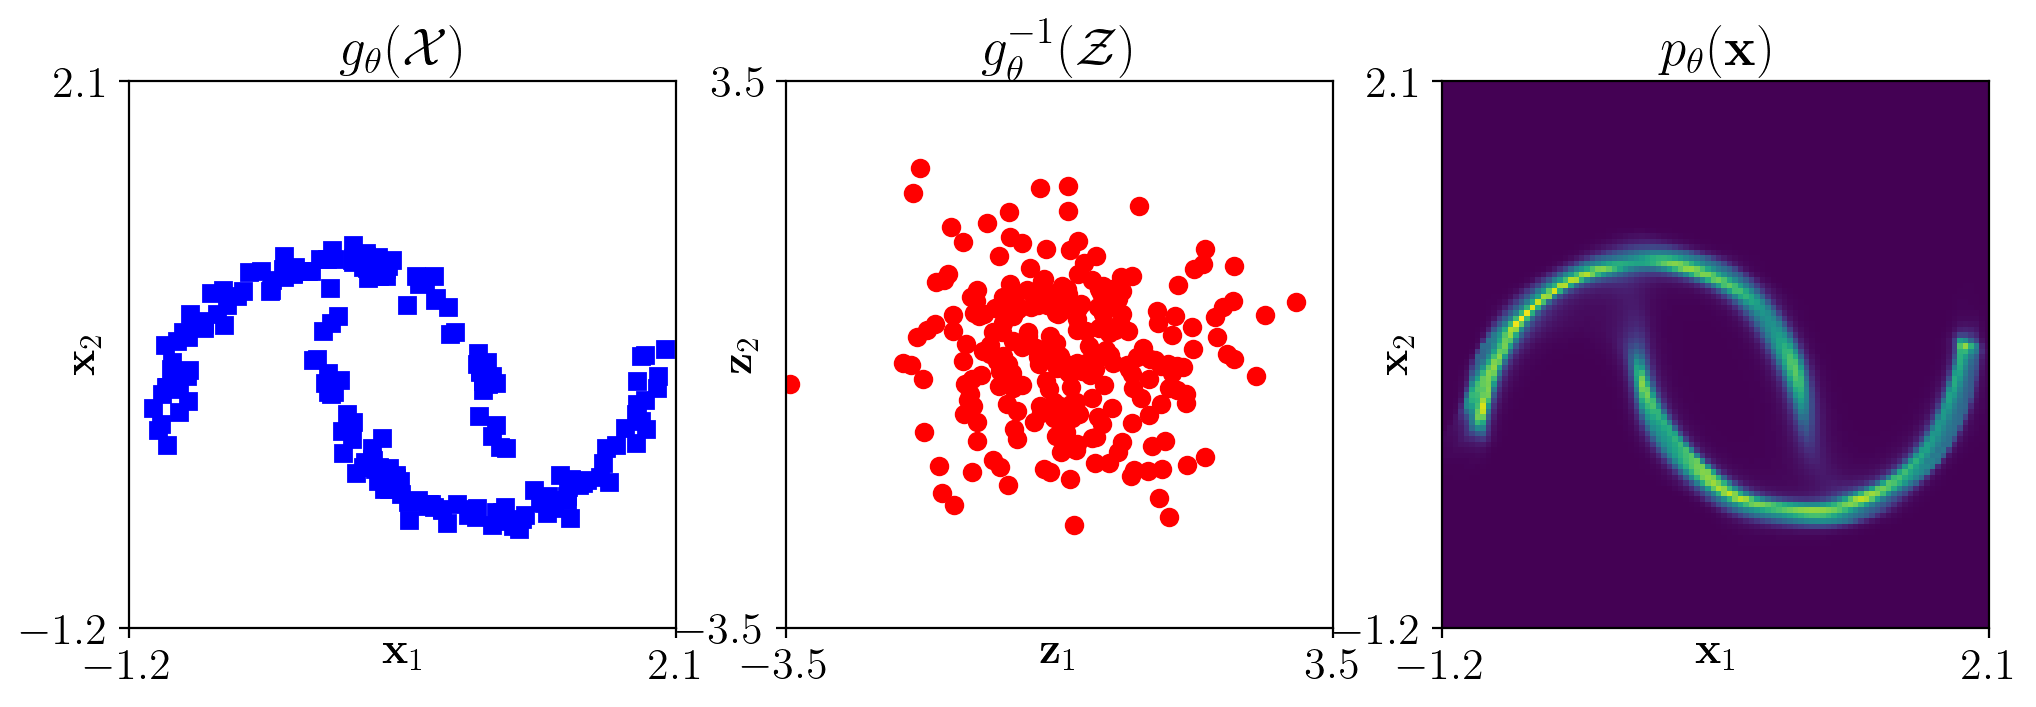

KeyboardInterrupt: 

In [15]:
batch_size = 256
num_steps = 20000      # number of training steps
out_file=None          # base filename saving trained model
plot_interval = 1000    # interval for visualizing intermediate results


optim = torch.optim.Adam(net.parameters(), lr=1e-2) # lr=0.04 good
his = np.zeros((0,4))



print((3*"--" + "device=%s, nTh=%d, width=%d, batch_size=%d, num_steps=%d" + 3*"--") % (device, nTh, width, batch_size, num_steps, ))

if out_file is not None:
    import os
    out_dir, fname = os.path.split(out_file)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    print((3*"--" + "out_file: %s" + 3*"--") % (out_file))

print((5*"%7s    ") % ("step","J", "J_L", "J_ML","J_HJB"))
train_J = 0.0
train_L = 0.0
train_JML = 0.0
num_step = 0
train_HJB = 0.0

for step in range(num_steps):

    x = get_data(batch_size)
    optim.zero_grad()
    log_prob,L,P = flow.log_prob(x)
    loss = (- alph[1]*log_prob + alph[0]*L + alph[2]*P).mean()
    loss.backward()
    optim.step()

    train_J += loss.item()
    train_L += L.mean().item()
    train_JML += - log_prob.mean().item()
    train_HJB += P.mean().item()
    num_step += 1

    if (step + 1) % plot_interval == 0:
        train_J /= num_step
        train_JML /= num_step
        train_L /= num_step
        train_HJB /= num_step


        print(("%06d   " + 4*"%1.4e  ") %
              (step + 1, train_J, train_L, train_JML, train_HJB))
        his = np.vstack([his, [train_J, train_L, train_JML, train_HJB]])
        train_J = 0.0
        train_L = 0.0
        train_JML = 0.0
        num_step = 0
        train_HJB = 0.0

        with torch.no_grad():
            zs = flow.ginv(x)[0].detach()
            xs = flow.sample(200).detach()
            log_px = flow.log_prob(xx)[0].detach()

            plt.Figure()
            plt.subplot(1,3,1)
            plot_x(xs,domain)
            plt.title("$g_{\\theta}(\mathcal{X})$")

            plt.subplot(1,3,2)
            plot_z(zs)
            plt.title("$g^{-1}_{\\theta}(\mathcal{Z})$")

            plt.subplot(1,3,3)
            plot_px(log_px.reshape(len(x1), len(x2)),domain)
            plt.title("$p_{\\theta}(\mathbf{x})$")
            plt.margins(0, 0)
        if out_file is not None:
            plt.savefig("%s-step-%d.png" % (out_file,step+1), bbox_inches='tight', pad_inches=0)
        plt.show()

if out_file is not None:
    torch.save(net.state_dict(), ("%s.pt") % (out_file))
    from scipy.io import savemat
    savemat(("%s.mat") % (out_file), {"his":his})

In [ ]:
plt.Figure()
plt.subplot(1,3,1)
plot_px(log_px,domain)
plot_x(xs[:64, :],domain)
plt.title("likelihood $p_{\boldsymbol{\theta}}(\mathbf{x})$ and samples $g_{\boldsymbol{\theta}}(\mathbf{x})")

xx = get_data(20000)
zz = flow.ginv(xx)[0].detach().numpy()

plt.subplot(1,3,2)

plot_pz(zz)
plot_z(zs[:64,:])

zall = torch.cat(flow.ginv(x)[2],1)

plt.subplot(1,3,3)
plt.plot(x[:, 0], x[:, 1], "bs",alpha=0.05)
plt.plot(zs[:, 0], zs[:, 1], "or",alpha=0.05)
plt.title("inverse of generator")

for k in range(6):
    zk = zall[k,:].reshape(-1,2)
    plt.plot(zk[:, 0], zk[:, 1], "-xk")
    plt.plot(zk[0, 0], zk[0, 1], "bs")
    plt.plot(zk[-1, 0], zk[-1, 1], "or")

plt.axis((-3.5, 3.5, -3.5, 3.5))
plt.xticks((-3.5, 3.5))
plt.yticks((-3.5, 3.5))
plt.margins(0, 0)
plt.show()
plt.title("hidden layers")